In [1]:
import pandas as pd
import numpy as np
import copy

# import matplotlib.pyplot as plt
# import seaborn as sns
# # sns.set()

# custom_params = {"axes.spines.right": False, 'grid.color': 'lightgray', 'axes.grid': True, "axes.spines.top": False}
# sns.set_theme(style="ticks", rc=custom_params)

from survivors import metrics as metr
from survivors import constants as cnt
from survivors import criteria as crit
from survivors import visualize as vis
import survivors.datasets as ds

In [2]:
import survivors.constants as cnt

### Построение непараметрических моделей

In [3]:
X, y, features, categ, sch_nan = ds.load_pbc_dataset()

In [4]:
bins = cnt.get_bins(time=y["time"], cens=y["cens"])

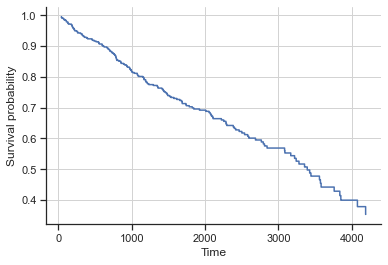

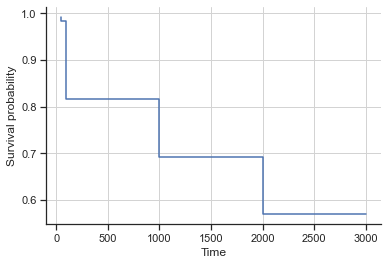

In [5]:
from survivors.external import KaplanMeier

# def plot_surival_function(sf, bins, title=""):
#     plt.step(bins, sf)
#     plt.xlabel('Time')
#     plt.ylabel('Survival probability')
#     plt.title(title)
#     plt.show()

km = KaplanMeier()
km.fit(durations=y["time"], right_censor=y["cens"])
sf_km = km.survival_function_at_times(times=bins)
vis.plot_surival_function(sf_km, bins)

bins_short = [50, 100, 1000, 2000, 3000]
sf_km_short = km.survival_function_at_times(times=bins_short)
vis.plot_surival_function(sf_km_short, bins_short)

In [6]:
bins.shape

(4151,)

### Построение индивидуальных прогнозов (деревья выживаемости)

In [7]:
from survivors.tree import CRAID

# Создание дерева выживаемости
cr = CRAID(criterion='logrank', depth=2, min_samples_leaf=0.1, signif=0.05,
           categ=categ, leaf_model="base", need_features=features.copy())

# Обучение дерева
cr.fit(X, y)

# Прогноз функции выживания для всех наблюдений выборки X
sf_cr = cr.predict_at_times(X, bins=bins, mode="surv")
chf_cr = cr.predict_at_times(X, bins=bins, mode="hazard")

# Визуализация структуры дерева
cr.visualize(target=cnt.TIME_NAME, mode="surv")

In [9]:
from survivors.tree import CRAID

# Создание дерева выживаемости
cr = CRAID(criterion='logrank', depth=0, min_samples_leaf=0.1, signif=0.05,
           categ=categ, leaf_model="CoxPH", leaf_penalizer=0.5, need_features=features.copy())

# Обучение дерева
cr.fit(X, y)

# Прогноз функции выживания для всех наблюдений выборки X
sf_cr = cr.predict_at_times(X, bins=bins, mode="surv")
chf_cr = cr.predict_at_times(X, bins=bins, mode="hazard")

# Визуализация структуры дерева
cr.visualize(target=cnt.TIME_NAME, mode="surv")

In [17]:
from lifelines import WeibullAFTFitter, LogNormalAFTFitter, LogLogisticAFTFitter, CoxPHFitter

X_ = X.copy()
X_[cnt.TIME_NAME] = y[cnt.TIME_NAME]
X_[cnt.CENS_NAME] = y[cnt.CENS_NAME]
X_ = X_.fillna(0).replace(np.nan, 0)

In [12]:
from survivors.external import WeibullAFT

w = WeibullAFT()
w.fit(X_)
w.predict_feature(X=None, feature_name=cnt.CENS_NAME)

NameError: name 'CoxPHFitter' is not defined

In [12]:
round(w.predict_feature(X=None, feature_name=cnt.CENS_NAME)[0], 2)

0.39

In [18]:
w = WeibullAFTFitter()
w.fit(X_, cnt.TIME_NAME, event_col=cnt.CENS_NAME)

<lifelines.WeibullAFTFitter: fitted with 418 total observations, 257 right-censored observations>

In [19]:
w.predict_cumulative_hazard(w._central_values, times=bins)

,baseline
41.0,0.000705
42.0,0.000731
43.0,0.000757
44.0,0.000783
45.0,0.000809
...,...
4187.0,0.670501
4188.0,0.670739
4189.0,0.670976
4190.0,0.671213


In [15]:
t = w.predict_survival_function(w._central_values, times=bins).to_numpy().T

In [16]:
list(t.flat)

[0.9989771234619125,
 0.9986848152430106,
 0.9983925925556917,
 0.9983194443101003,
 0.9982463014237895,
 0.9981731638963662,
 0.9981000317274381,
 0.9980269049166125,
 0.9979537834634968,
 0.9978806673676986,
 0.9978075566288253,
 0.9977775757608844,
 0.997747595793771,
 0.9977176167274581,
 0.9976876385619183,
 0.997657661297125,
 0.9976276849330508,
 0.9975977094696686,
 0.9975677349069516,
 0.9975377612448726,
 0.9975077884834045,
 0.9974778166225203,
 0.9974478456621929,
 0.9974178756023954,
 0.9973879064431005,
 0.9973579381842812,
 0.9973279708259105,
 0.9972980043679615,
 0.9972680388104068,
 0.9972380741532195,
 0.9972081103963727,
 0.9971074817216159,
 0.9970068632013395,
 0.9969062548345187,
 0.996805656620129,
 0.9967050685571459,
 0.996604490644545,
 0.9965680349073183,
 0.9965315805036404,
 0.9964951274334626,
 0.996458675696736,
 0.996422225293412,
 0.9963857762234417,
 0.9963493284867764,
 0.9963128820833672,
 0.9962764370131655,
 0.9962399932761224,
 0.9962035508721893

In [18]:
w.__dict__

{'alpha': 0.05,
 '_class_name': 'WeibullAFTFitter',
 '_label': None,
 '_censoring_type': <CensoringType.RIGHT: 'right'>,
 'penalizer': 0.0,
 'l1_ratio': 0.0,
 '_fitted_parameter_names': ['lambda_', 'rho_'],
 'fit_intercept': True,
 'model_ancillary': False,
 'duration_col': 'time',
 'event_col': 'cens',
 'entry_col': None,
 'weights_col': None,
 'durations': 0       400.0
 1      4500.0
 2      1012.0
 3      1925.0
 4      1504.0
         ...  
 413     681.0
 414    1103.0
 415    1055.0
 416     691.0
 417     976.0
 Name: time, Length: 418, dtype: float64,
 '_time_fit_was_called': '2024-02-21 07:05:20 UTC',
 '_n_examples': 418,
 'robust': False,
 'timeline': array([  41.,   43.,   51.,   71.,   77.,   94.,  110.,  111.,  130.,
         131.,  140.,  179.,  186.,  191.,  193.,  198.,  207.,  216.,
         221.,  223.,  249.,  264.,  304.,  321.,  326.,  334.,  348.,
         359.,  388.,  400.,  460.,  466.,  489.,  515.,  533.,  549.,
         552.,  559.,  597.,  611.,  617.,  62

In [8]:
chf_cr.shape

(418, 4151)

In [9]:
print(cr.predict(X, target=cnt.TIME_NAME)[0])
print(cr.predict(X, target=cnt.CENS_NAME)[0])
print(cr.predict(X, target="depth")[0])

847.4363403320312
0.9272727272727272
2.0


In [10]:
y[0]

(True, 400.)

In [11]:
pred_time = cr.predict(X, target=cnt.TIME_NAME)
print(pred_time[0])
pred_prob = cr.predict(X, target=cnt.CENS_NAME)
print(pred_prob[0])
pred_depth = cr.predict(X, target="depth")
print(pred_depth[0])
# pred_size = cr.predict(X, target="size")

# for f in features:
#     pred = cr.predict(X, target=f)
#     print(f, pred[0], X.iloc[0][f])

847.4363403320312
0.9272727272727272
2.0


### Построение ансамблей деревьев выживаемости

In [12]:
from survivors.ensemble import BootstrapCRAID

# Создание дерева выживаемости
bstr = BootstrapCRAID(n_estimators=10, size_sample=0.7, ens_metric_name='IBS_REMAIN', 
                      max_features=0.3, criterion='peto', depth=10,
                      min_samples_leaf=0.01, categ=categ, leaf_model="base")

# Обучение дерева
bstr.fit(X, y)

# Прогноз функции выживания для всех наблюдений выборки X
sf_bstr = bstr.predict_at_times(X, bins=bins, mode="surv")

fitted: 10 models.


### Оценка качества прогнозов

In [13]:
mean_ibs = metr.ibs(y, y, sf_bstr, bins, axis=-1)
print(mean_ibs)  # 0.071
ibs_by_obs = metr.ibs(y, y, sf_bstr, bins, axis=0)
print(ibs_by_obs)  # [0.0138, 0.038, ..., 0.0000, 0.0007]
ibs_by_time = metr.ibs(y, y, sf_bstr, bins, axis=1)
print(ibs_by_time)  # [0.0047, 0.0037, ..., 0.0983, 0.3533]

0.07103180378576936
[1.38310643e-02 3.86891635e-02 7.19790397e-02 1.78881217e-01
 9.64078950e-03 1.45654992e-01 1.21325403e-03 6.93200687e-02
 9.16266624e-02 1.17177825e-02 1.50434853e-01 1.57464960e-01
 1.63953655e-04 6.78695088e-02 2.16969635e-01 0.00000000e+00
 1.19138420e-01 1.01534143e-02 1.72933020e-01 6.59590674e-02
 1.97266937e-02 2.85005402e-02 8.28969746e-03 6.02149223e-01
 1.24986905e-02 2.05555231e-01 1.59449224e-02 2.48413686e-02
 9.06364108e-02 7.25070495e-02 5.40397304e-01 3.75989741e-02
 1.20288047e-01 2.76132071e-02 2.74931733e-01 2.27720671e-02
 9.42423025e-03 3.79438626e-01 1.57204172e-01 3.74975048e-01
 7.30564873e-02 3.36760361e-01 3.40519563e-02 6.66502793e-02
 7.05256062e-04 1.62428358e-01 5.65366611e-03 5.53860972e-01
 2.20547117e-01 9.17826541e-02 2.01834084e-01 1.67148971e-01
 5.60118742e-02 1.73121474e-01 9.33674205e-02 3.57143616e-01
 3.80924552e-01 1.48069186e-01 2.28364731e-01 2.01243587e-01
 1.49656504e-01 2.39657658e-01 4.58463052e-02 7.61890689e-02
 1.7

In [14]:
ibs_by_time.shape

(4151,)

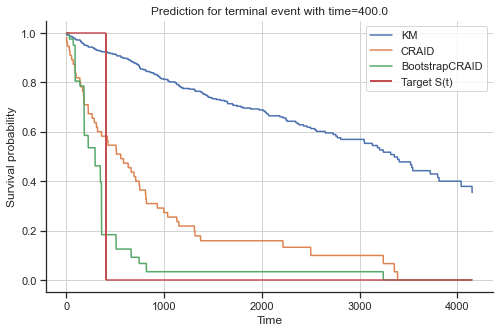

In [17]:
vis.plot_func_comparison(y[0],
                     [sf_km, sf_cr[0], sf_bstr[0]], 
                     ["KM", "CRAID", "BootstrapCRAID"])

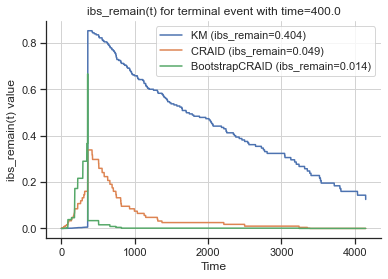

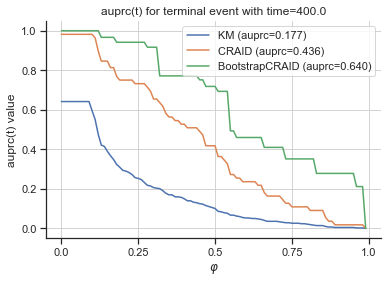

In [19]:
vis.plot_metric_comparison(y[0], [sf_km, sf_cr[0], sf_bstr[0]], ["KM", "CRAID", "BootstrapCRAID"], bins, metr.ibs_remain)
vis.plot_metric_comparison(y[0], [sf_km, sf_cr[0], sf_bstr[0]], ["KM", "CRAID", "BootstrapCRAID"], bins, metr.auprc)